# ANALYSE D'ÉVÈNEMENT, MORIN HEIGHTS
## Évènement de verglas du 5-6 avril 2023
 __*Comparaison des mesures de la staiton UQAM_PK <br>et des accumulations estimées par l'utilisation de relation statistiques <br>sur les données de stations SYGIVRES à proximité de Montréal*__

Auteur : Matisse Larocque [ LARM09069805 ] <br>
Version : juillet 2025 <br>



# IMPORTS

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime,timedelta
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.cm as cm  # pour la colormap

import os
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm
from scipy import stats
import sys  
sys.path.insert(0, '/instruments/resources/scripts/')
sys.path.insert(0, '/instruments/resources/scripts/mrr/')
sys.path.insert(0, '/instruments/resources/scripts/parsivel/')
sys.path.insert(0, '/instruments/resources/scripts/met_data/')
sys.path.insert(0, '/instruments/resources/scripts/ceilometer/')

import other_functions
import met_data_functions
import parsivel_functions


# IDENTIFICATION DE L'ÉVÈNEMENT

In [2]:
# IMPORT DATES
start,end = datetime(2023,4,4),datetime(2023,4,8)

# EVENT INTERVAL
start_event = pd.to_datetime("2023-04-05 08:00:00")
end_event = pd.to_datetime("2023-04-06 00:00:00")

# IMPORTATION DES DONNÉES : UQAM_PK


## PATH et FICHIERS

### Données de la station

In [3]:
path = '/instruments/LAURENTIDES/Morin_Heights/'
station_string = 'LN_MH_'
#files_prefix1 = 'UP_PR_DIS_RAW_'
files_prefix1 = 'LN_MH_DIS_'
current = datetime(2023,4,1)

# FIGURE OUTPUT
fig_output_path = "/home/larocque/CODES/FIGURES_DEPOT/"

#### Données, MetTripod et Ice Detector

In [4]:
# MetTripod, importation manuelle
# (Les fonctions d'importation n'ont pas le bon pathways, met_data != met_tripod)

filepath = path+'met_tripod/'+\
    str(current.year)+'_'+str(current.month).zfill(2)+\
    '/master/'+\
    station_string+'MET_01_MAS_'+str(current.year)+str(current.month).zfill(2)+'.txt'

In [5]:
df_met_all = pd.read_csv(
    filepath,
    parse_dates=['Timestamp'],      # Colonne à parser en datetime
    index_col='Timestamp'           # Utiliser la colonne datetime comme index
)

In [6]:
# Données du Ice Detector, si disponible
df_ice_all = other_functions.import_multi_df(start,end,station_string,path,met_data_functions.import_ice_data_master)


Importing master ice data..


#### Données, Disdromètre (OTT Parsivel)

In [7]:
# Dates for disdrometer data - no requiment for summer months
dis_dates = ['2023_04']

In [8]:
files = []
for date in dis_dates:
    files.append(f'{path}parsivel/{date}/master/{station_string}DIS_MAS_{date.replace("_","")}.txt')
files.sort()

In [9]:
files

['/instruments/LAURENTIDES/Morin_Heights/parsivel/2023_04/master/LN_MH_DIS_MAS_202304.txt']

In [10]:
df_list = [pd.read_csv(file,header=0, index_col=0, parse_dates=True, engine='c', low_memory=False) for file in files]

In [11]:
df_Parsivel = pd.concat(df_list)

# IMPORTATION DES DONNÉES : SYGIVRE
#### Les csv importés sont déjà formattés, et tout les calculs relatifs à ma revue de littérature sont déjà inclus

In [12]:
# Files organisées par un autre script dans ce directory
sygivre_data_path = "/chinook/larocque/DATA_HQ/EventFiles/"
event = "avril2023"
sygivre_stations = [ file for file in os.listdir(sygivre_data_path) if f'{event}' in file ]



In [13]:
sygivre_stations

['CHENIER_C_avril2023.csv',
 'HERTEL_C_avril2023.csv',
 'STJOVITE_C_avril2023.csv',
 'LANAUD_C_avril2023.csv']

In [14]:
# ADAPTER : 
# <station>_df = pd.read_csv(
#        os.path.join(sygivre_data_path, sygivre_stations[<position>]),
#         index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
#         parse_dates=['timestamp']       # Convertit en datetime
# )

In [15]:
chenier_df = pd.read_csv(
       os.path.join(sygivre_data_path, sygivre_stations[0]),
        index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
        parse_dates=['timestamp']       # Convertit en datetime
)

In [16]:
stjovite_df = pd.read_csv(
           os.path.join(sygivre_data_path, sygivre_stations[2]),
        index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
        parse_dates=['timestamp']       # Convertit en datetime
)

In [17]:
lanaud_df = pd.read_csv(
       os.path.join(sygivre_data_path, sygivre_stations[3]),
        index_col='timestamp',          # Utilise la colonne 'timestamp' comme index
        parse_dates=['timestamp']       # Convertit en datetime
)

# Constantes et fonctions

In [18]:
DbiFS=[0.062,0.187,0.312,0.437,0.562,0.687,0.812,0.937,1.062,1.187,1.375,1.625,1.875,2.125,2.375,2.750,3.25,3.75,4.25,4.75,5.5,6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24]     
vTbiFS=[0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.10,1.30,1.5,1.7,1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,17.6,20.80]

#...Gamme de valeurs de diamètre et vitesse de chute de chaque bins
Dspread = [0.125 ,0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.250, 0.250, 0.250, 0.250, 0.250, 
           0.500, 0.500, 0.500, 0.500, 0.500, 1.000, 1.000, 1.000, 1.000, 1.000, 2.000, 2.000, 2.000, 2.000, 2.000, 3.000, 3.000]
Vspread = [0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.100, 0.200, 0.200, 0.200, 0.200, 0.200,
0.400, 0.400, 0.400, 0.400, 0.400, 0.800, 0.800, 0.800, 0.800, 0.800, 1.600, 1.600, 1.600, 1.600, 1.600, 3.200, 3.200]


In [19]:
dfit = np.arange(0,23,0.1)
# 2) lump graupel        
def vlumpg_g(x):
    return 1.3*x**0.66    # ishikana
def vrain(x):
    return 3.78*(x**0.67)
def vlumpg_c(x):
    return 7.33*((x*0.1)**0.89)   # rasmusshan
def vdry(x):
    return 1.07*((x*0.1)**(0.2))
def vwet(x):
    return 2.14*(x*0.1)**0.2 

# NOUVEAUX DATAFRAMES POUR ANALYSE

### Dataframe avec données combinées Met + Parsivel + Ice Detector
### Données chaque minute

In [20]:
# Align columns to new dataframe to ensure continuity of index
# SYNOP_WaWa is SYNOP table 4680
# Intensity_of_precipitation is in mm/h, measured every minute

analysis_1T_df = df_Parsivel[['Intensity of precipitation (mm/h)']].copy()
analysis_1T_df.rename(columns = {'Intensity of precipitation (mm/h)':'Intensity_of_precipitation'}, inplace = True)

In [21]:
analysis_1T_df['air_temp'] = df_met_all.Air_Temp.copy() # °C
analysis_1T_df['ice_mm'] = df_ice_all.Ice_mm.copy() # mm

analysis_1T_df.loc[analysis_1T_df["ice_mm"] < 0.13, "ice_mm"] = 0.0

In [22]:
# add column to calculate ice depth each minute (mm)

analysis_1T_df['ice_amount'] = analysis_1T_df.ice_mm.diff() # mm

# set negative values to zero
analysis_1T_df.loc[analysis_1T_df["ice_amount"] < 0, "ice_amount"] = 0.0 #mm

In [23]:
# Precip amount each minute

analysis_1T_df['precip_amount'] = analysis_1T_df['Intensity_of_precipitation'] / 60 #mm/min

In [24]:
# Ice rate (mm/hr)

analysis_1T_df['ice_rate'] = analysis_1T_df.ice_amount * 60

In [25]:
# Accretion efficiency coefficient

analysis_1T_df['accretion_coeff'] = analysis_1T_df.ice_amount / analysis_1T_df.precip_amount

In [26]:
analysis_1T_df.columns

Index(['Intensity_of_precipitation', 'air_temp', 'ice_mm', 'ice_amount',
       'precip_amount', 'ice_rate', 'accretion_coeff'],
      dtype='object')

In [27]:
analysis_1T_df['ice_summed'] = analysis_1T_df.ice_amount.cumsum()

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

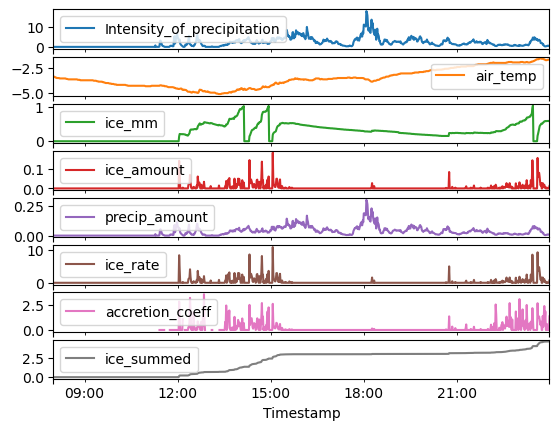

In [28]:
analysis_1T_df[start_event:end_event].plot(subplots = True)


/tmp/larocque-jacta/2019059/ipykernel_2075857/2571732451.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(columns))


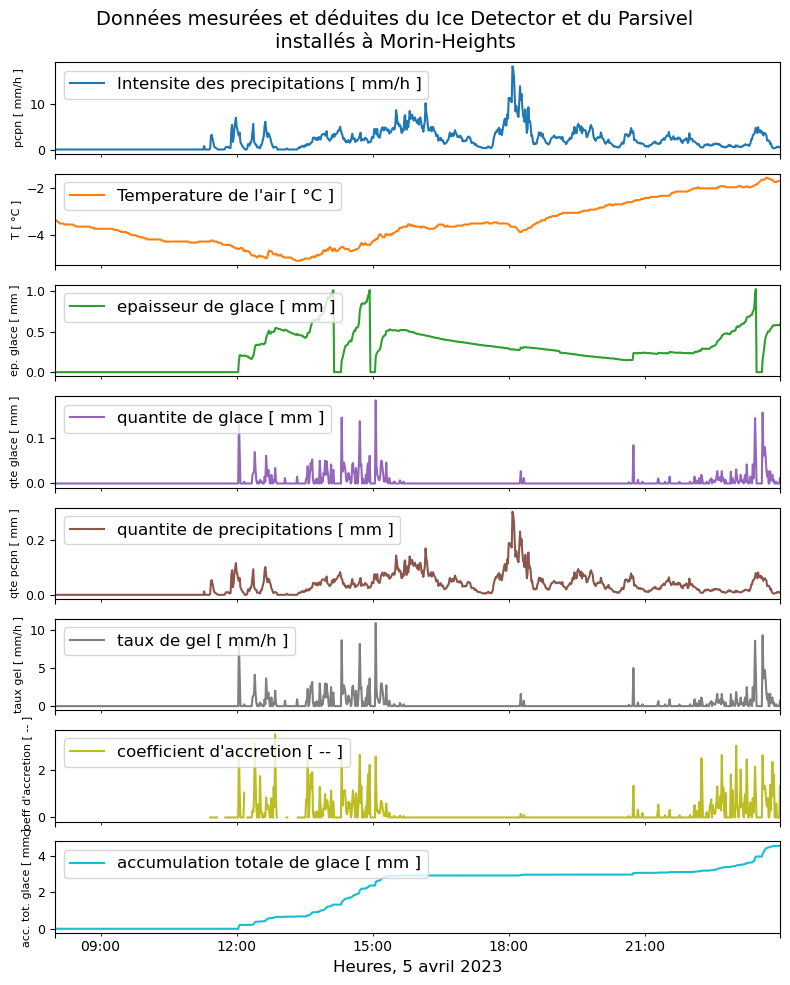

In [29]:
fig_df = analysis_1T_df[start_event:end_event]

columns = fig_df.columns[:]

legends = [ "Intensite des precipitations [ mm/h ]", # Intensity of pcpn
            "Temperature de l'air [ °C ]", # air temp
            "epaisseur de glace [ mm ]", # ice_mm
            "quantite de glace [ mm ]", # ice_amount
            "quantite de precipitations [ mm ]", # precip_amount
            "taux de gel [ mm/h ]", # ice_rate
            "coefficient d'accretion [ -- ]", # accretion coefficient
            "accumulation totale de glace [ mm ]"] # ice_summed

ylabels = [ "pcpn [ mm/h ]", # Intensity of pcpn
            "T [ °C ]", # air temp
            "ep. glace [ mm ]", # ice_mm
            "qte glace [ mm ]", # ice_amount
            "qte pcpn [ mm ]", # precip_amount
            "taux gel [ mm/h ]", # ice_rate
            "coeff d'accretion [ -- ]", # accretion coefficient
            "acc. tot. glace [ mm ]"] #ice_summed

# Colormap (tu peux changer pour 'tab10', 'Set2', 'Dark2', etc.)
colormap = cm.get_cmap('tab10', len(columns))
colors = [colormap(i) for i in range(len(columns))]

# Création des subplots manuellement
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 10), sharex=True)

fig.suptitle("Données mesurées et déduites du Ice Detector et du Parsivel\n"+\
             "installés à Morin-Heights", fontsize=14)

for i, (col, ylabel, legend_label) in enumerate(zip(columns, ylabels, legends)):
    ax = axes[i]
    fig_df[col].plot(ax=ax, label=legend_label, color = colors[i])
    ax.set_ylabel(ylabel, fontsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.legend(loc='upper left', fontsize=12)
              
ax.set_xlabel("Heures, 5 avril 2023", fontsize = 12)
          
    

plt.tight_layout()
plt.savefig(fig_output_path + "MH_UQAM_DATA_apr5_2023.png") #MODIFIER
plt.show()

### Données moyennes du réseau sygivre et des relations statistiques pour le calcul de l'accumulation de glace

In [30]:
# Colonnes d’intérêt
cols = [col for col in chenier_df.columns if col.endswith("mm")]

chenier_filtered = chenier_df.loc[start_event:end_event, cols]
stjovite_filtered = stjovite_df.loc[start_event:end_event, cols]
lanaud_filtered = lanaud_df.loc[start_event:end_event, cols]


In [31]:
sygivre_AverageOutput_df = (chenier_filtered + stjovite_filtered + lanaud_filtered) / 3


In [32]:
sygivre_AverageOutput_df.columns

Index(['R35_FzRa_0mm', 'R12_FzRa_0mm', 'R315_FzRa_0mm', 'R35_min_Rime_0mm',
       'R12_min_Rime_0mm', 'R315_min_Rime_0mm', 'R35_max_Rime_0mm',
       'R12_max_Rime_0mm', 'R315_max_Rime_0mm', 'ACC_RAJ_FzRa_0mm'],
      dtype='object')

#### Analyse, étapes 3a à 3c

In [33]:
sygivre_AverageOutput_df['FzRa_average'] = sygivre_AverageOutput_df[[ col for col in sygivre_AverageOutput_df.columns if ("FzRa" in col) and ("RAJ" not in col)]].mean(axis=1)

In [34]:
sygivre_AverageOutput_df['Rime_average'] = sygivre_AverageOutput_df[[col for col in sygivre_AverageOutput_df.columns if "Rime" in col]].mean(axis=1)

In [35]:
sygivre_AverageOutput_df['acc_average']=sygivre_AverageOutput_df[cols].mean(axis=1)

In [36]:
sygivre_AverageOutput_df.columns

Index(['R35_FzRa_0mm', 'R12_FzRa_0mm', 'R315_FzRa_0mm', 'R35_min_Rime_0mm',
       'R12_min_Rime_0mm', 'R315_min_Rime_0mm', 'R35_max_Rime_0mm',
       'R12_max_Rime_0mm', 'R315_max_Rime_0mm', 'ACC_RAJ_FzRa_0mm',
       'FzRa_average', 'Rime_average', 'acc_average'],
      dtype='object')

#### Analyse, étapes 4a à 4d

In [37]:
analysis_1T_df.columns

Index(['Intensity_of_precipitation', 'air_temp', 'ice_mm', 'ice_amount',
       'precip_amount', 'ice_rate', 'accretion_coeff', 'ice_summed'],
      dtype='object')

In [38]:
# Accumulations en fonction du taux de précipitation moyen aux 10 min, disdromètre

analysis_10T_df=analysis_1T_df[
    ['Intensity_of_precipitation','ice_amount']
].resample('10min').agg({
    'Intensity_of_precipitation':'mean',
    'ice_amount':'sum',
    
})

In [39]:
analysis_10T_df = analysis_10T_df[start_event:end_event].copy()

In [40]:
analysis_10T_df['ice_summed'] = analysis_10T_df.ice_amount.cumsum()

In [41]:
# analysis_10T_df

In [42]:
# Gestion des données du disdromètre pour avoir la vitesse et la taille de chute moyens

data_bins = df_Parsivel[start_event:end_event].iloc[:,5::].to_numpy().astype(float)
data_bins[data_bins == 0] = np.nan
n_times = data_bins.shape[0]



In [43]:
data_array = data_bins.reshape(n_times, 32, 32)

Dbins = np.array(DbiFS)
vTbins = np.array(vTbiFS)

In [44]:


# --- Moyenne des dimensions (somme sur vitesses → axe=1)
dim_counts = np.nansum(data_array, axis=1)  # (n_times, 32 diamètres)
weighted_dim = np.nansum(dim_counts * Dbins, axis=1)
total_dim = np.nansum(dim_counts, axis=1)
D_moyenne = weighted_dim / total_dim
D_moyenne[total_dim == 0] = np.nan

# --- Moyenne des vitesses (somme sur diamètres → axe=2)
vit_counts = np.nansum(data_array, axis=2)  # (n_times, 32 vitesses)
weighted_vit = np.nansum(vit_counts * vTbins, axis=1)
total_vit = np.nansum(vit_counts, axis=1)
V_moyenne = weighted_vit / total_vit
V_moyenne[total_vit == 0] = np.nan

# Index temporel
X = df_Parsivel[start_event:end_event].index

# Dataframe de sortie (index = temps, col1 = Vmoy, col2 = Dmoy)
df_parsivel_stats = pd.DataFrame({
    'Vitesse_moyenne': V_moyenne,
    'Dimension_moyenne': D_moyenne
}, index=X).resample('10min').mean()

analysis_10T_df['Vit_moy'] = df_parsivel_stats['Vitesse_moyenne'].copy()
analysis_10T_df['Dim_moy'] = df_parsivel_stats['Dimension_moyenne'].copy()

/tmp/larocque-jacta/2019059/ipykernel_2075857/1177103234.py:5: RuntimeWarning: invalid value encountered in divide
  D_moyenne = weighted_dim / total_dim
/tmp/larocque-jacta/2019059/ipykernel_2075857/1177103234.py:12: RuntimeWarning: invalid value encountered in divide
  V_moyenne = weighted_vit / total_vit


In [45]:
analysis_10T_df

,Intensity_of_precipitation,ice_amount,ice_summed,Vit_moy,Dim_moy
Timestamp,,,,,
2023-04-05 08:00:00,0.000000,0.000,0.000,NaN,NaN
2023-04-05 08:10:00,0.000000,0.000,0.000,NaN,NaN
2023-04-05 08:20:00,0.000000,0.000,0.000,NaN,NaN
2023-04-05 08:30:00,0.000000,0.000,0.000,NaN,NaN
2023-04-05 08:40:00,0.000000,0.000,0.000,NaN,NaN
...,...,...,...,...,...
2023-04-05 23:20:00,3.202400,0.339,3.960,3.031491,0.903202
2023-04-05 23:30:00,3.823900,0.373,4.333,3.281768,0.957351
2023-04-05 23:40:00,1.784500,0.198,4.531,3.074049,0.858015


#### Analyse, étape 6

In [46]:
# Rééchantillonnage aux 10 minutes
df_10min = sygivre_AverageOutput_df.resample('10min').asfreq()

# On interpole linéairement les valeurs manquantes
sygivre_10min_interpolated = df_10min.interpolate(method='linear')


In [47]:
analysis_10T_df['acc_diff'] = analysis_10T_df[start_event:end_event]["ice_summed"] - sygivre_10min_interpolated["acc_average"]

## TIME SERIES

### DATAFRAMES À UTILISER : (disponibles)
- tous les 'station_df'
- sygivre_AverageOutput_df
- sygivre_10min_interpolated
- analysis_1T_df
- analysis_10T_df


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

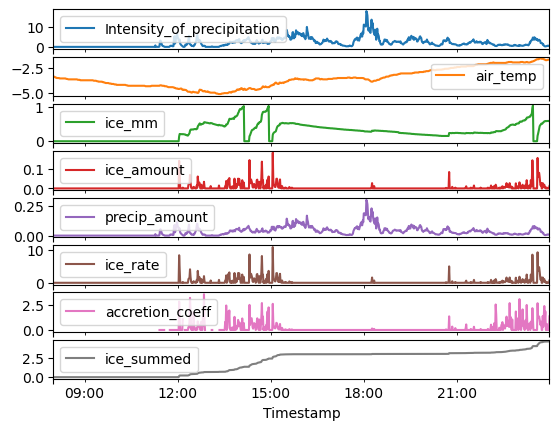

In [48]:
analysis_1T_df[start_event:end_event].plot(subplots=True)

/tmp/larocque-jacta/2019059/ipykernel_2075857/1684721720.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', len(columns))


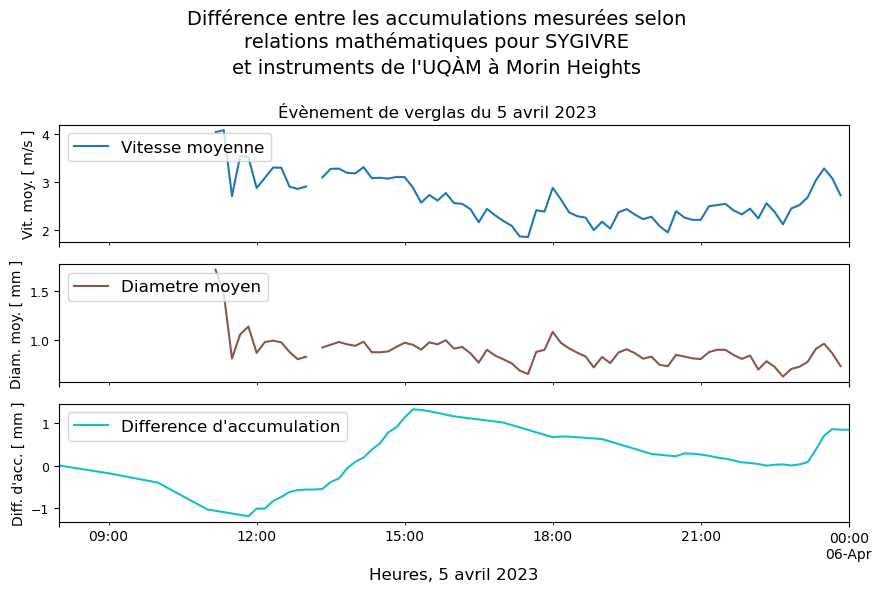

In [49]:
df = analysis_10T_df[['Vit_moy','Dim_moy','acc_diff']]
df.index = pd.to_datetime(df.index)

# Noms des colonnes
columns = df.columns

# Y-labels (unités)
ylabels = [
    "Vit. moy. [ m/s ]",
    "Diam. moy. [ mm ]",
    "Diff. d'acc. [ mm ]"
]

# Légendes
legends = [
    "Vitesse moyenne",
    "Diametre moyen",
    "Difference d'accumulation"
]

# Couleurs différentes
colormap = cm.get_cmap('tab10', len(columns))
colors = [colormap(i) for i in range(len(columns))]

# Créer les subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 6), sharex=True)
fig.suptitle("Différence entre les accumulations mesurées selon\n"+\
                "relations mathématiques pour SYGIVRE\n"+\
             "et instruments de l'UQÀM à Morin Heights", fontsize=14)

fig.text(0.5,0.8, "Évènement de verglas du 5 avril 2023", ha='center', fontsize=12)

# Tracer chaque variable
for i, (col, ylabel, legend_label) in enumerate(zip(columns, ylabels, legends)):
    ax = axes[i]
    df[col].plot(ax=ax, label=legend_label, color=colors[i])
    ax.set_ylabel(ylabel, fontsize=10)
    ax.legend(loc='upper left', fontsize=12)
    ax.tick_params(axis='y', labelsize=9)

ax.set_xlabel("Heures, 5 avril 2023", fontsize = 12)

# Mise en page
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(fig_output_path+"MH_UQAM-SYGIVRE-DIFF_apr5_2023.png") # MODIFIER
plt.show()


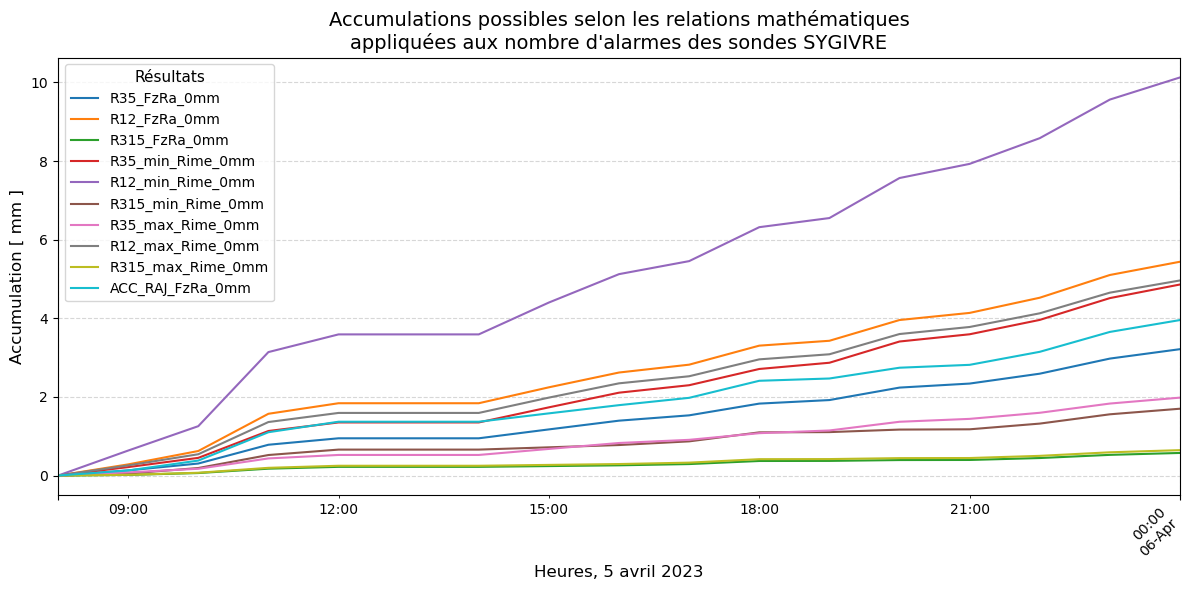

In [50]:
#RÉSULTATS DES RELATIONS MATHÉMATIQUES SUR SYGIVRE

fig, ax = plt.subplots(figsize=(12, 6))

# Tracé principal
sygivre_AverageOutput_df[[c for c in sygivre_AverageOutput_df.columns if 'average' not in c]].plot(ax=ax)

# Titre principal
ax.set_title("Accumulations possibles selon les relations mathématiques\n"+\
             "appliquées aux nombre d'alarmes des sondes SYGIVRE", fontsize=14)

# Étiquettes des axes
ax.set_xlabel("Heures, 5 avril 2023", fontsize=12)
ax.set_ylabel("Accumulation [ mm ]", fontsize=12)  # Remplace par l’unité réelle

# Formatage de l’axe X pour afficher date et heure
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Légende
ax.legend(title="Résultats", fontsize=10, title_fontsize=11)

# Grille optionnelle
ax.grid(True, linestyle='--', alpha=0.5)

# Ajustement de l’espace
plt.tight_layout()

# Sauvegarde
plt.savefig(fig_output_path+"MH_SYGIVRE-EQ-RES_apr5_2023.png", dpi=300)

# Affichage
plt.show()


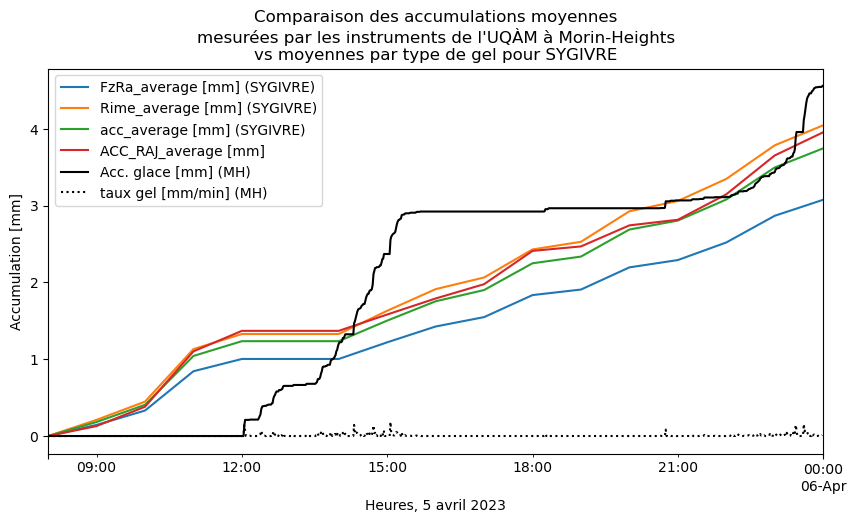

In [51]:
# Créer une figure
plt.figure(figsize=(10, 5))

for col in [c for c in sygivre_AverageOutput_df.columns if "average" in c]:
    sygivre_AverageOutput_df.loc[start_event:end_event, col].plot(ax=plt.gca(), label=col + " [mm] (SYGIVRE)")

sygivre_AverageOutput_df.loc[start_event:end_event, 'ACC_RAJ_FzRa_0mm'].plot(ax=plt.gca(), label='ACC_RAJ_average' + " [mm] ")

# Tracer la courbe "ice_amount" de analysis_1T_df par-dessus
analysis_1T_df[start_event:end_event]['ice_amount'].cumsum().plot(ax=plt.gca(), color='black', linestyle='-', label='Acc. glace [mm] (MH)')

# Tracer la courbe "ice_amount" de analysis_1T_df par-dessus
analysis_1T_df[start_event:end_event]['ice_amount'].plot(ax=plt.gca(), color='black', linestyle='dotted', label='taux gel [mm/min] (MH)')

# Ajouter légende, titre, axes si tu veux
plt.legend()
plt.title("Comparaison des accumulations moyennes\nmesurées par les instruments de l'UQÀM à Morin-Heights\nvs moyennes par type de gel pour SYGIVRE")
plt.xlabel("Heures, 5 avril 2023")
plt.ylabel("Accumulation [mm]")

plt.savefig(fig_output_path+"MH_COMPARE_ACC_apr5_2023.png")
# Afficher le graphique
plt.show()

In [52]:
# Pour l'analyse, le dataframe utilisé doit avoir les colonnes "Dim_moy", "Vit_moy" et "acc_diff"

analysis_10T_clean = analysis_10T_df.dropna().copy()

# --- Corrélations
pearson_dim = stats.pearsonr(analysis_10T_clean["Dim_moy"], analysis_10T_clean["acc_diff"])
spearman_dim = stats.spearmanr(analysis_10T_clean["Dim_moy"], analysis_10T_clean["acc_diff"])

pearson_vit = stats.pearsonr(analysis_10T_clean["Vit_moy"], analysis_10T_clean["acc_diff"])
spearman_vit = stats.spearmanr(analysis_10T_clean["Vit_moy"], analysis_10T_clean["acc_diff"])

print("\n--- Corrélations ---")
print(f"Pearson DimMoy: r = {pearson_dim[0]:.3f}, p = {pearson_dim[1]:.3f}")
print(f"Spearman DimMoy: r = {spearman_dim.correlation:.3f}, p = {spearman_dim.pvalue:.3f}")
print(f"Pearson VitMoy: r = {pearson_vit[0]:.3f}, p = {pearson_vit[1]:.3f}")
print(f"Spearman VitMoy: r = {spearman_vit.correlation:.3f}, p = {spearman_vit.pvalue:.3f}")

# --- Catégoriser par quantiles pour ANOVA
analysis_10T_clean["Dim_class"] = pd.qcut(analysis_10T_clean["Dim_moy"], q=4, labels=False)
analysis_10T_clean["Vit_class"] = pd.qcut(analysis_10T_clean["Vit_moy"], q=4, labels=False)

anova_dim = stats.f_oneway(*[
    analysis_10T_clean.loc[analysis_10T_clean["Dim_class"] == i, "acc_diff"]
    for i in range(4)
])
anova_vit = stats.f_oneway(*[
    analysis_10T_clean.loc[analysis_10T_clean["Vit_class"] == i, "acc_diff"]
    for i in range(4)
])

print("\n--- ANOVA par quantiles ---")
print(f"DimMoy : F = {anova_dim.statistic:.2f}, p = {anova_dim.pvalue:.3f}")
print(f"VitMoy : F = {anova_vit.statistic:.2f}, p = {anova_vit.pvalue:.3f}")

# --- Régression linéaire multiple

X = analysis_10T_clean[["Dim_moy", "Vit_moy"]].values
y = analysis_10T_clean["acc_diff"].values
model = LinearRegression().fit(X, y)

print("\n--- Régression linéaire multiple ---")
print(f"R² = {model.score(X, y):.3f}")
print(f"Coefficients : DimMoy = {model.coef_[0]:.3f}, VitMoy = {model.coef_[1]:.3f}")
print(f"Intercept = {model.intercept_:.3f}")

# Régression linéaire multiple avec p-values
X = analysis_10T_clean[["Dim_moy", "Vit_moy"]]
y = analysis_10T_clean["acc_diff"]

# Ajoute une constante (intercept)
X = sm.add_constant(X)

# Fit du modèle
model = sm.OLS(y, X).fit()

# Résumé complet du modèle avec p-values
print("\n--- Régression linéaire multiple (avec p-values) ---")
print(model.summary())


--- Corrélations ---
Pearson DimMoy: r = -0.327, p = 0.004
Spearman DimMoy: r = -0.038, p = 0.744
Pearson VitMoy: r = -0.506, p = 0.000
Spearman VitMoy: r = -0.344, p = 0.002

--- ANOVA par quantiles ---
DimMoy : F = 1.80, p = 0.155
VitMoy : F = 5.19, p = 0.003

--- Régression linéaire multiple ---
R² = 0.269
Coefficients : DimMoy = 0.793, VitMoy = -0.923
Intercept = 2.045

--- Régression linéaire multiple (avec p-values) ---
                            OLS Regression Results                            
Dep. Variable:               acc_diff   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     13.43
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           1.08e-05
Time:                        11:28:28   Log-Likelihood:                -66.726
No. Observations:                  76   AIC:                             139.5
Df Residuals:   

__À la station Trois-Rivières, il n'y a pas de Ice Detector disponible. Je vais tenter d'obtenir une règle pour l'efficacité d'accrétion en fonction de la température pour un évènement de précipitation mixte, en fonction des données ici (même évènement, mais plus à l'ouest)__

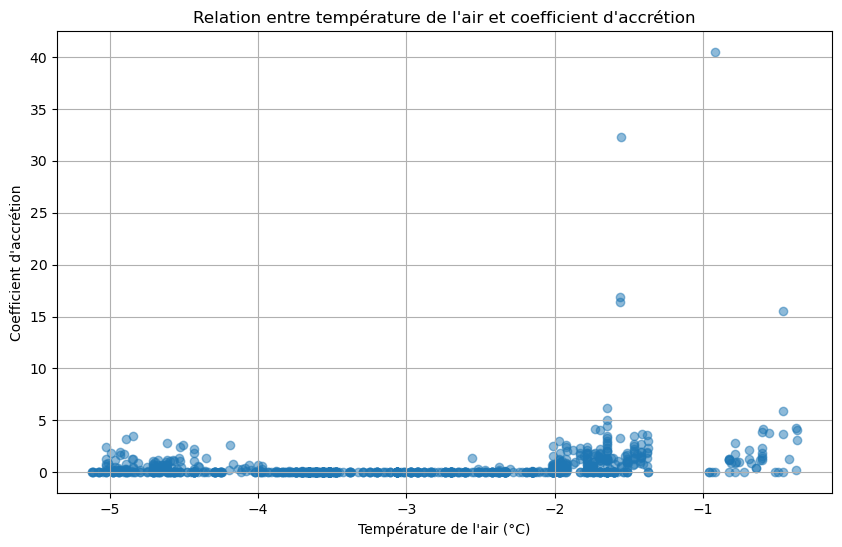

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(analysis_1T_df['air_temp'], analysis_1T_df['accretion_coeff'], alpha=0.5)
plt.xlabel("Température de l'air (°C)")
plt.ylabel("Coefficient d'accrétion")
plt.title("Relation entre température de l'air et coefficient d'accrétion")
plt.grid(True)
plt.show()


In [54]:
# Enlever les valeurs manquantes

# Garder seulement les lignes finies et sans NaN
df_valid = analysis_1T_df[['air_temp', 'accretion_coeff']].replace([np.inf, -np.inf], np.nan).dropna()

X = df_valid['air_temp'].values.reshape(-1, 1)
y = df_valid['accretion_coeff'].values

print(f"Nombre de points valides : {len(df_valid)}")


Nombre de points valides : 901


In [55]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

print(f"Modèle linéaire : accretion_coeff ≈ {slope:.4f} × air_temp + {intercept:.4f}")


Modèle linéaire : accretion_coeff ≈ 0.3982 × air_temp + 1.7304


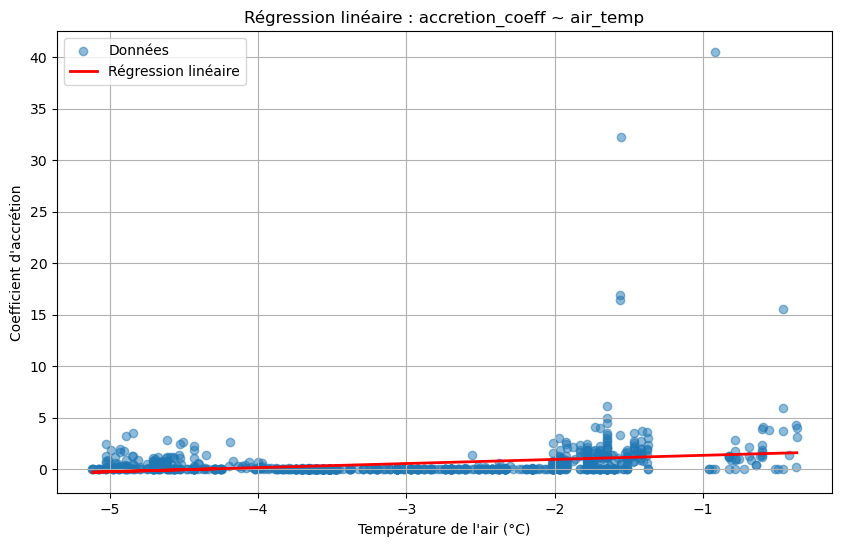

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Données')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Régression linéaire')
plt.xlabel("Température de l'air (°C)")
plt.ylabel("Coefficient d'accrétion")
plt.title("Régression linéaire : accretion_coeff ~ air_temp")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
from sklearn.metrics import mean_squared_error, r2_score

# Prédictions
y_pred = model.predict(X)

# R²
r2 = r2_score(y, y_pred)

# Erreur quadratique moyenne
mse = mean_squared_error(y, y_pred)

print(f"R² (coefficient de détermination) : {r2:.4f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")


R² (coefficient de détermination) : 0.0527
Erreur quadratique moyenne (MSE) : 4.1982


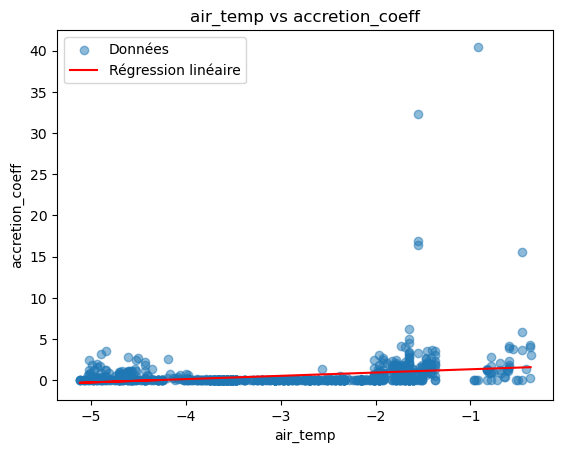

In [58]:

plt.scatter(X, y, alpha=0.5, label='Données')
plt.plot(X, y_pred, color='red', label='Régression linéaire')
plt.xlabel('air_temp')
plt.ylabel('accretion_coeff')
plt.legend()
plt.title("air_temp vs accretion_coeff")
plt.show()

In [59]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model_poly = LinearRegression()
model_poly.fit(X_poly, y)

y_pred_poly = model_poly.predict(X_poly)

r2_poly = r2_score(y, y_pred_poly)
print(f"R² (polynomiale degré 2) : {r2_poly:.4f}")


R² (polynomiale degré 2) : 0.1106


In [60]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Colonnes à utiliser
features = ['air_temp', 'Intensity_of_precipitation']
target = 'accretion_coeff'

# Sous-ensemble du DataFrame
df_subset = analysis_1T_df[features + [target]].copy()

# Supprimer les NaN et les infinis
df_clean = df_subset.replace([np.inf, -np.inf], np.nan).dropna()

# Définir X et y
X = df_clean[features]
y = df_clean[target]

# Régression linéaire multiple
model = LinearRegression()
model.fit(X, y)

# Prédictions et évaluation
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Affichage des résultats
print(f"R² (régression linéaire multiple, 2 variables) : {r2:.4f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")
for f, c in zip(features, model.coef_):
    print(f"Coefficient pour {f} : {c:.4f}")
print(f"Intercept : {model.intercept_:.4f}")


R² (régression linéaire multiple, 2 variables) : 0.0618
Erreur quadratique moyenne (MSE) : 4.1577
Coefficient pour air_temp : 0.3328
Coefficient pour Intensity_of_precipitation : -0.0970
Intercept : 1.7600


## FIGURES - DISDROMETER

In [61]:
# # Disdrometer figures from FRZN events

# # Subset of data
# spectrum = df_Parsivel[start_event:end_event].iloc[:, 14::]
# resample_data = spectrum.sum(axis = 0)

# resample_data = resample_data.replace(0, np.nan)
# b = resample_data.values.reshape(32,32)
# b = np.ma.masked_where(np.isnan(b),b)

# plt.style.use('seaborn-v0_8-ticks')
# fig, ax = plt.subplots(1,1, figsize=(7,3.5), dpi=300, facecolor='white')
# X,Y = np.meshgrid(DbiFS,vTbiFS)
# pc = ax.pcolormesh(X,Y,np.log10(b) , alpha=0.75, cmap='rainbow', vmin=0, vmax=4.5)
# yo2 = fig.colorbar(pc,ticks=[0,1,2,3,4], fraction=0.02, pad=0.01, label='Particle count')
# yo2.ax.set_yticklabels([r'$1$',r'$10$',r'$100$',r'$1000$', r'$10000$'])

# #pc = ax.pcolormesh(X,Y,b, alpha=.75, cmap="rainbow")
# #fig.colorbar(pc, orientation="vertical", fraction=0.02, pad=0.01, label='Partical count')
# #ax.scatter(x=Dmoy,y=Vmoy, s=200, marker='+', color="red" )
# ax.set_xlim(0,20)
# ax.set_ylim(0,10)
# plt.plot(dfit,vrain(dfit),'g',label=u"Rain", linewidth=1.)
# plt.plot(dfit,vlumpg_g(dfit), 'black', label=u"Snow Pellets", linewidth=1., linestyle='-')
# plt.plot(dfit,vwet(dfit),'r',label=u"Wet Snow", linewidth=1.)
# plt.plot(dfit,vdry(dfit), 'b', label=u"Dry Snow", linewidth=1.)

# for vT in vTbiFS:
#     plt.axhline(y=vT, xmin=0., xmax=10, linewidth=0.2, color = 'k')   
# for D in DbiFS:
#     plt.axvline(x=D, ymin=0.0, ymax = 18, linewidth=0.2, color='k')

# plt.xticks([2,4,6,8,10,12,14,16,18,20])

# plt.axis((0,DbiFS[30],0,vTbiFS[28]))
# ax.set_xlim([0,5])
# ax.set_ylim([0,10])
# plt.xlabel('Diameter (mm)')
# plt.ylabel('Fall Speed (m s$^{-1}$)')
# fig1 = plt.gcf()
# plt.legend(loc='upper right', fontsize=8)
# plt.title('UQAM PK', loc='left', fontsize=8)
# plt.title(f'Valid: {start_event} - {end_event} ', loc='right', fontsize=8)